In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from preprocessing import encoding_sorted, encode_one_hot, prepare_existing_data, download_raw_data, add_features
from charts_and_write import *
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier



# Voting Ensemble
Vamos a utilizar un ensamble entre los mejores modelos que tenemos hasta el momento. Con voting ensemble vamos a predecir con distintos modelos y se va a elegir para cada predicción a la clase con mas votos. Este tipo de tecnica es muy efectiva cuando usamos resultados con poca correlación entre si.

Los modelos que elegimos para hacer el ensamble fueron Gradient Boosting, Logistic Regression y Decision Tree, los 3 con los hiperparametros que resultaron en su mejor score auc-roc en sus respectivos notebooks.

La transformación que vamos a elegir para el dataset crudo es la de encodear la mayoria de los features con one hot encoding, excepto por educacion, edad y bolsa, que tienen sus transformaciones propias con orden: Edad se divide en deciles, bolsa se divide en dos separaciones de cuartiles tanto para negativos como para positivos, y educacion en franjas (primaria, secundaria, etc).

## Preprocesamiento

En nuestro script preprocessing.py tenemos definidas ya funciones que nos van a servir para descargar los datos crudos y luego prepararlos para luego poder aplicarle ingeniería de features

In [23]:
download_raw_data()

In [24]:
#datasets train-test y holdout 
data_train = pd.read_csv("impuestos_train.cvs")
data_holdout = pd.read_csv("impuestos_holdout.cvs")
#llenamos los nulls y borramos columnas que no se usan
data_train, data_holdout = prepare_existing_data(data_train, data_holdout)


## Selección de features 1


Podemos usar los features que ya vienen en el dataset y ademas generar nuevos a partir de ellos. Para empezar de entrada vamos a descartar algunos que ya en el TP1 vimos que no aportaban como son barrio y educacion alcanzada. 
Luego, de los features ya existentes va a haber un grupo, los categoricos, que al no ser numericos vamos a tener que utilizar un encodeo para poder entrenar el modelo. La mayoria de ellos no tienen un orden entonces vamos a usar nuestra función de one hot encoding, que genera una columna nueva por cada valor posible. Para el caso de los que sí tienen orden vamos a utilizar un encodeo propio con la funcion "encoding_sorted". Ambas funciones estan en el script de preprocessing.py.


In [25]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "trabajo", "genero", "religion"]
data_train_v1 = encode_one_hot(data_train, columns_one_hot)
columns_sorted_numeric = ["educacion"]
data_train_v1 = encoding_sorted(data_train_v1, columns_sorted_numeric)
data_train_v1 = add_features(data_train_v1, "working_years_higher_than_27")
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(data_train_v1.drop(columns={"tiene_alto_valor_adquisitivo"}), data_train_v1["tiene_alto_valor_adquisitivo"], random_state=42)

In [26]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, criterion='friedman_mse')
clf2 = LogisticRegression(C= 0.001, penalty = 'l2', solver='newton-cg',random_state=0)
clf3 = DecisionTreeClassifier( criterion='gini', max_depth=10, min_samples_leaf = 38)

In [27]:
eclf1 = VotingClassifier(estimators=[('boosting', clf1), ('lr', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train_v1, y_train_v1)
y_pred = eclf1.predict(X_test_v1)
show_metrics(eclf1, y_pred, y_test_v1, X_test_v1, "Ensemble")

Accuracy: 0.8663554845842034
----------------------------------------------
Precision: 0.5781006746237675
----------------------------------------------
Recall: 0.8020158387329014
----------------------------------------------
F1_score: 0.6718938480096501
----------------------------------------------
AUC-ROC score para Ensemble: 0.919


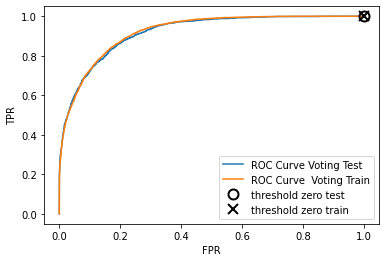

In [28]:
show_roc_curve(eclf1,"Voting",X_test_v1, X_train_v1, y_test_v1, y_train_v1)

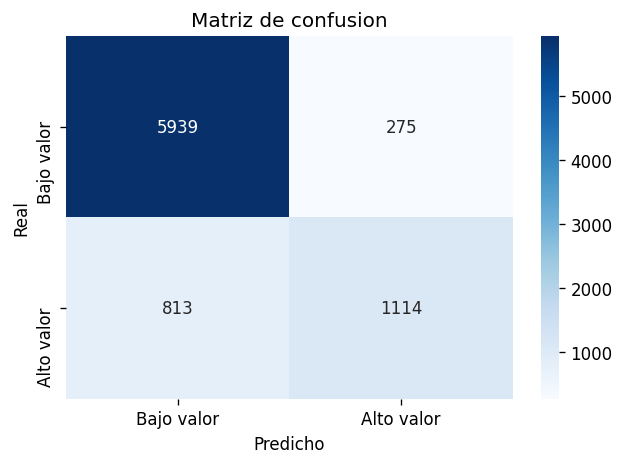

In [29]:
y_pred = eclf1.predict(X_test_v1)
show_confusion_matrix(y_pred,y_test_v1)

## Selección de features 2

Para la segunda selección vamos a agregar features obtenidos a partir del analisis del TP1, que son la transformación de edad a decil y de gancnaias en bolsa a cuartil.
El feature edad lo vamos a reemplazar por el decil al que pertenece en el dataset de entrenamiento, y vamos a reemplazar el feature de ganancias y perdidas en la bolsa por uno "bolsa" que representará el cuartil al que pertenece, en caso de ganancia, 0 en caso de no tener actividad, y un valor negativo correspondiente al cuartil en el caso de perdidas. Así, los casos que mas perdida tienen van a tener el valor -4, y los que mas ganancia tienen van a tener el valor 4.


In [30]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "trabajo", "genero", "religion"]
data_train_v2 = encode_one_hot(data_train,columns_one_hot)
columns_sorted_numeric = ["educacion", "edad", "bolsa"]
data_train_v2 = encoding_sorted(data_train_v2, columns_sorted_numeric)
data_train_v2 = add_features(data_train_v2, "working_years_higher_than_27")
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(data_train_v2.drop(columns={"tiene_alto_valor_adquisitivo"}), data_train_v2["tiene_alto_valor_adquisitivo"], random_state=42)

In [31]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, criterion='friedman_mse')
clf2 = LogisticRegression(C= 0.001, penalty = 'l2', solver='newton-cg',random_state=0)
clf3 = DecisionTreeClassifier( criterion='gini', max_depth=10, min_samples_leaf = 38)

In [32]:
eclf1 = VotingClassifier(estimators=[('boosting', clf1), ('lr', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train_v2, y_train_v2)
y_pred = eclf1.predict(X_test_v2)
show_metrics(eclf1, y_pred, y_test_v2, X_test_v2, "Ensemble")

Accuracy: 0.8658641444539983
----------------------------------------------
Precision: 0.5786196159833938
----------------------------------------------
Recall: 0.7992831541218638
----------------------------------------------
F1_score: 0.6712823600240819
----------------------------------------------
AUC-ROC score para Ensemble: 0.920


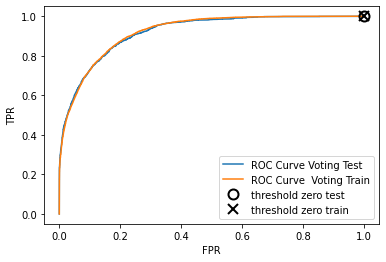

In [33]:
show_roc_curve(eclf1,"Voting",X_test_v2, X_train_v2, y_test_v2, y_train_v2)

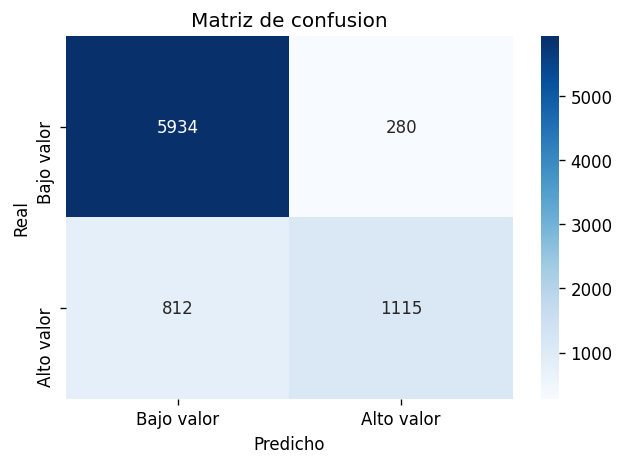

In [34]:
y_pred = eclf1.predict(X_test_v2)
show_confusion_matrix(y_pred,y_test_v2)

# Resultado

Ambas selecciones dieron resultados muy parecidos en casi todas las metricas, pero nos quedamos con la segunda ya que tiene un auc mayor.

In [35]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
columns_sorted_numeric = ["educacion", "edad", "bolsa"]
data_holdout = encode_one_hot(data_holdout, columns_one_hot)
data_holdout = encoding_sorted(data_holdout, columns_sorted_numeric)
data_holdout = add_features(data_holdout, "working_years_higher_than_27")


Guardamos las predicciones

In [36]:
best_clf = VotingClassifier(estimators=[('boosting', clf1), ('lr', clf2), ('dt', clf3)], voting='soft')
best_clf.fit(X_train_v2, y_train_v2)
preds = best_clf.predict(data_holdout.drop(columns="id"))
ids = np.array(data_holdout['id'])
write_predictions(preds,"Voting",ids)